In [258]:
from Algorithms.clarke_wright import ClarkeWright
from Algorithms.client import Client
from datetime import datetime, timedelta
import random
import names
import numpy as np
import matplotlib.pyplot as plt
# random seed
random.seed(42)

# Generate historized client data

In [259]:
def generate_clients(start_date, end_date, min_slots, max_slots, locations, max_timeslot_picks, timeslot_usage, num_clients=1, batch_size=1):
    date_format = "%Y-%m-%d"
    start_date = datetime.strptime(start_date, date_format)
    end_date = datetime.strptime(end_date, date_format)
    date_range = (end_date - start_date).days
    
    timeslots = ['morning', 'evening']
    clients = []
    
    success = 0
    fail = 0

    for _ in range(num_clients):
        clientgenerated = True
        name = names.get_full_name()  # Generating random full names
        location = random.choice(locations)
        
        while True:
            # Generate all possible availability slots within the entire date range
            possible_slots = []
            for day in (start_date + timedelta(days=i) for i in range(date_range + 1)):
                for timeslot in timeslots:
                    slot = f"{day.strftime(date_format)}_{timeslot}"
                    if timeslot_usage.get(slot, 0) < max_timeslot_picks:
                        possible_slots.append(slot)

            if len(possible_slots) < min_slots:
                fail += 1
                clientgenerated = False
                break
            
            random.shuffle(possible_slots)
            # Pick a random number of slots between min_slots and max_slots
            availability = possible_slots[:random.randint(min_slots, max_slots)]

            # Generate appointment day that is before or on the same day as the latest timeslot in availability
            latest_slot_day = max(datetime.strptime(slot.split('_')[0], date_format) for slot in availability)
            appointment_day = start_date + timedelta(days=random.randint(0, (latest_slot_day - start_date).days))
            appointment_hour = random.randint(0, 23)
            appointment_minute = random.randint(0, 59)
            appointment_time = datetime.combine(appointment_day, datetime.min.time()) + timedelta(hours=appointment_hour, minutes=appointment_minute)
            appointment_time_str = appointment_time.strftime(f"{date_format} %H:%M:%S")

            for slot in availability:
                timeslot_usage[slot] = timeslot_usage.get(slot, 0) + 1
            
            if len(availability) >= min_slots:
                break

        if clientgenerated:
            success += 1
            client = Client(name, location, availability, appointment_time_str)
            clients.append(client)
    
    return clients, success, fail

# test online case

In [260]:
def get_definitive_timeslot_clarke(clients, scheduled_definitive_appointments, distance_matrix_path):
    success, fail = 0, 0
    print("start")
    if not isinstance(clients, list):
        clients = [clients]
    amountclients = len(clients)
    old_routes = []
    new_routes = []
    
    # Gather all availability slots for the batch of clients
    scheduledslots = []
    allslots = []
    for client in clients:
        scheduledslots.extend([slot for slot in client.availability if slot in scheduled_definitive_appointments])
        allslots.extend([slot for slot in client.availability if slot not in allslots])
    
    # If there are no appointments scheduled yet in the availability slots just schedule the clients
    if not scheduledslots:
        print("if")
        for slot in allslots:
            try:
                clarkewright = ClarkeWright(clients)
                clarkewright.solve(slot, distance_matrix_path)
                clientsforslot = []
                for client in clients:
                    if slot in client.availability:
                        clientsforslot.append(client)
                scheduled_definitive_appointments[slot] = [clientsforslot, clarkewright.get_solution()]
            except:
                continue
        return scheduled_definitive_appointments, len(clients) , 0
    else:
        print(("else"))
        # If there are appointments scheduled in the availability slots, try to add the clients to the existing routes with the minimal cost
        for slot in scheduledslots:
            
            clientsforslot = []
            for client in clients:
                if slot in client.availability:
                    print(f"\nSlot: {slot}, Client: {client.name}, Location: {client.location}, Availability: {client.availability}")
                    clientsforslot.append(client)
                    clients.remove(client)
                    
            if clientsforslot:
                old_routes.append([scheduled_definitive_appointments[slot], slot])
                      
                clients_new = scheduled_definitive_appointments[slot][0] + clientsforslot
                clarkewright_new = ClarkeWright(clients_new)
                clarkewright_new.solve(slot, distance_matrix_path)
                new_routes.append([[clientsforslot, clarkewright_new.get_solution()], slot])
            
    
        # Compare the costs of all routes and pick the route with the smallest delta
        min_delta = float('inf')
        best_route = None
        for old_route, new_route in zip(old_routes, new_routes):
            old_cost = old_route[0][1][1]  # Extracting the cost from the old route
            new_cost = new_route[0][1][1]  # Extracting the cost from the new route
            # convert string 1h34min to minutes
            old_cost = int(old_cost.split('h')[0])*60 + int(old_cost.split('h')[1].split('min')[0])
            new_cost = int(new_cost.split('h')[0])*60 + int(new_cost.split('h')[1].split('min')[0])
            delta = new_cost - old_cost
            if delta < min_delta:
                min_delta = delta
                best_route = new_route
        
        # Update the scheduled_definitive_appointments with the best route
        if best_route:
            slot = best_route[1]
            scheduled_definitive_appointments[slot] = [best_route[0][0], best_route[0][1]]
            return scheduled_definitive_appointments, amountclients, 0
    
    return scheduled_definitive_appointments, 0, amountclients


In [261]:

config = {
    'num_clients': 150,
    'start_date': "2024-06-01",
    'end_date': "2024-07-29",
    'min_slots': 2,
    'max_slots': 3,
    'locations': ['Asten Heusden Ommel', 'Deurne Vlierden', 'Geldrop', 'Gemert Handel', 'Helmond',
                  'Helmond Brandevoort', 'Mierlo', 'Nuenen Gerwen Nederwetten', 'Someren'],
    'distance_matrix_path': "..//Data//distance_matrix.csv",
    'max_timeslot_picks': 3  # Maximum number of timeslots a single slot can be picked
}



In [262]:
def online_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}
    messsage_counter = {}
    success = 0
    fail = 0
    
    for _ in range(config['num_clients']):
        clients, success1, fai1 = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=1)
        fail += fai1
        
        if success1 !=0:
            client = clients[0]
            scheduled_definitive_appointments, success2, fail2 = get_definitive_timeslot_clarke(client, scheduled_definitive_appointments, config['distance_matrix_path'])
            success += success2
            fail += fail2
            
    # Collect travel time per day
    for slot, details in scheduled_definitive_appointments.items():
        day = slot.split('_')[0]
        # convert string 1h34min to minutes
        daily_travel_time[day] = int(details[1][1].split('h')[0])*60 + int(details[1][1].split('h')[1].split('min')[0])           

            
    return daily_travel_time, success, fail, scheduled_definitive_appointments     

In [263]:
print("Online Use Case Results:")
scheduled_definitive_appointments_batch = {}
online_data, success, fail, scheduled_definitive_appointments_batch[1]    = online_use_case(config)
print(f" Success: {success}, Fail: {fail}")
print("Daily Travel Time:", online_data)

Online Use Case Results:
start
if
start
if
start
if
start
if
start
if
start
if
start
else

Slot: 2024-06-28_morning, Client: Edward Mclean, Location: Helmond Brandevoort, Availability: ['2024-06-28_morning', '2024-06-22_morning']
start
else

Slot: 2024-07-24_evening, Client: Craig Reader, Location: Deurne Vlierden, Availability: ['2024-06-13_morning', '2024-07-24_evening']
start
if
start
else

Slot: 2024-06-02_morning, Client: Janice Mesa, Location: Geldrop, Availability: ['2024-06-02_morning', '2024-06-13_evening', '2024-07-23_morning']
start
if
start
if
start
if
start
if
start
if
start
if
start
else

Slot: 2024-07-24_evening, Client: Louise Charles, Location: Nuenen Gerwen Nederwetten, Availability: ['2024-07-16_evening', '2024-07-11_evening', '2024-07-24_evening']
start
if
start
if
start
if
start
if
start
if
start
if
start
if
start
if
start
if
start
else

Slot: 2024-07-29_morning, Client: Keith Norris, Location: Mierlo, Availability: ['2024-07-02_evening', '2024-07-29_morning']
star

# test offline case

In [264]:
def offline_use_case(config):
    scheduled_definitive_appointments = {}
    timeslot_usage = {}
    daily_travel_time = {}

    total_clients = config['num_clients']
    batch_size = config['batch_size']
    num_batches = (total_clients + batch_size - 1) // batch_size  # Calculate the number of batches

    clients_generated = 0
    messsage_counter = {}
    success = 0
    fail = 0
    
    for _ in range(num_batches):
        # Calculate how many clients to generate in this batch
        clients_in_batch = min(batch_size, total_clients - clients_generated)
        
        batch_clients, success1, fai1 = generate_clients(config['start_date'], config['end_date'], config['min_slots'], config['max_slots'], config['locations'], config['max_timeslot_picks'], timeslot_usage, num_clients=clients_in_batch)
        print(f"Batch size: {batch_size}, Success: {success1}, Fail: {fai1}")
  
        fail += fai1
        
        if success1 !=0:
            scheduled_definitive_appointments, success2, fail2 = get_definitive_timeslot_clarke(batch_clients, scheduled_definitive_appointments, config['distance_matrix_path'])
            success += success2
            fail += fail2
            
        clients_generated += clients_in_batch
        if clients_generated >= total_clients:
            break
            
    # Collect travel time per day
    for slot, details in scheduled_definitive_appointments.items():
        day = slot.split('_')[0]
        travel_time = details[1][1]
        hours, minutes = map(int, travel_time.replace('h', ' ').replace('min', '').split())
        daily_travel_time[day] = hours * 60 + minutes

    return daily_travel_time, success, fail, scheduled_definitive_appointments     


In [265]:
print("Generating Offline Use Case Data...")
batch_sizes = [2, 3, 5, 8, 10, 15, 25] # Different batch sizes to test
offline_data = {}

for batch_size in batch_sizes:
    offline_config = config.copy()
    offline_config['batch_size'] = batch_size
    offline_data[batch_size], success, fail, scheduled_definitive_appointments_batch[batch_size] = offline_use_case(offline_config)
    print(f"Batch size: {batch_size}, Success: {success}, Fail: {fail}")


Generating Offline Use Case Data...
Batch size: 2, Success: 2, Fail: 0
start
if
Batch size: 2, Success: 2, Fail: 0
start
if
Batch size: 2, Success: 2, Fail: 0
start
if
Batch size: 2, Success: 2, Fail: 0
start
else

Slot: 2024-06-26_evening, Client: Suzanne Davis, Location: Gemert Handel, Availability: ['2024-06-26_evening', '2024-06-01_morning', '2024-06-29_evening']
Batch size: 2, Success: 2, Fail: 0
start
if
Batch size: 2, Success: 2, Fail: 0
start
if
Batch size: 2, Success: 2, Fail: 0
start
else

Slot: 2024-07-25_morning, Client: Dawn Ruckman, Location: Deurne Vlierden, Availability: ['2024-07-23_evening', '2024-07-25_morning', '2024-07-16_evening']

Slot: 2024-07-04_evening, Client: David Garcia, Location: Helmond Brandevoort, Availability: ['2024-07-06_morning', '2024-06-07_morning', '2024-07-04_evening']
Batch size: 2, Success: 2, Fail: 0
start
else

Slot: 2024-07-04_evening, Client: Patricia Kanas, Location: Gemert Handel, Availability: ['2024-06-29_evening', '2024-07-04_evening

In [266]:
print(offline_data[15])
print(scheduled_definitive_appointments_batch[15])

{'2024-07-25': 195, '2024-07-01': 162, '2024-06-09': 60, '2024-06-17': 150, '2024-07-28': 92, '2024-06-28': 177, '2024-07-05': 152, '2024-06-04': 150, '2024-06-14': 90, '2024-07-27': 98, '2024-07-15': 154, '2024-06-15': 116, '2024-06-30': 158}
{'2024-07-25_evening': [[<Algorithms.client.Client object at 0x000001D859448D30>, <Algorithms.client.Client object at 0x000001D8354E8370>], (['Mierlo', 'Gemert Handel', 'Someren', 'Mierlo'], '3h15min')], '2024-07-01_evening': [[<Algorithms.client.Client object at 0x000001D85A763BB0>], (['Mierlo', 'Helmond Brandevoort', 'Asten Heusden Ommel', 'Mierlo'], '2h42min')], '2024-06-09_evening': [[<Algorithms.client.Client object at 0x000001D858B79C30>], (['Mierlo', 'Mierlo', 'Mierlo'], '1h0min')], '2024-06-17_morning': [[<Algorithms.client.Client object at 0x000001D85AF4C0D0>, <Algorithms.client.Client object at 0x000001D859560FD0>], (['Mierlo', 'Nuenen Gerwen Nederwetten', 'Mierlo', 'Mierlo'], '2h30min')], '2024-07-28_evening': [[<Algorithms.client.Clie

In [267]:
def plot_travel_times(online_data, offline_data, batch_sizes):
    dates = sorted(set(str(date) for date in online_data.keys()).union(set(str(date) for date in offline_data[batch_sizes[0]].keys())))
    online_times = [online_data.get(date, 0) for date in dates]
    offline_times = {batch_size: [offline_data[batch_size].get(date, 0) for date in dates] for batch_size in batch_sizes}
    print(dates)
    # Plot the total travel time for each method
    plt.figure(figsize=(12, 6))
    plt.plot(dates, online_times, label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.plot(dates, offline_times[batch_size], label=f'Offline (batch size: {batch_size})')
    plt.xlabel('Date')
    plt.ylabel('Total Travel Time (minutes)')
    plt.title('Total Travel Time per Day: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate and plot the cumulative travel time for each method
    plt.figure(figsize=(12, 6))
    plt.plot(dates, np.cumsum(online_times), label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.plot(dates, np.cumsum(offline_times[batch_size]), label=f'Offline {batch_size}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Travel Time (minutes)')
    plt.title('Cumulative Travel Time over Weeks: Online vs Offline')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot the average daily travel time for each method
    # but also add the days where no clients were scheduled to the average calculation
    online_avg = sum(online_times) / len(dates)
    offline_avgs = {batch_size: sum(offline_times[batch_size]) / len(dates) for batch_size in batch_sizes}
    plt.figure(figsize=(12, 6))
    plt.bar('Online', online_avg, label='Online (one by one)')
    for batch_size in batch_sizes:
        plt.bar(f'Offline{batch_size}', offline_avgs[batch_size], label=f'Offline (batch size: {batch_size})')   
    plt.xlabel('Method')
    plt.ylabel('Average Daily Travel Time (minutes)')
    plt.title('Average Daily Travel Time: Online vs Offline')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # fit a non linear regression model to the data

    # create a dataframe
    import pandas as pd
    df = pd.DataFrame({'Average Daily Travel Time (minutes)': [online_avg] + list(offline_avgs.values())}, index=[1] + [batch_size for batch_size in batch_sizes]) 
    print(df)
    # fit a non linear regression model
    from scipy.optimize import curve_fit
    def func(x, a, b):
        return a * np.exp(b * x)
    x = df.index
    y = df['Average Daily Travel Time (minutes)']
    popt, pcov = curve_fit(func, x, y)

    # plot the data and the model
    # extrapolate the model to the next batch size up to 50
    x = np.arange(25)
    y = func(x, *popt)
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, label='Model')
    plt.scatter(df.index, df['Average Daily Travel Time (minutes)'], color='red', label='Data')
    plt.xlabel('Method')
    plt.ylabel('Average Daily Travel Time (minutes)')
    plt.title('Average Daily Travel Time: Online vs Offline')
    plt.legend()
    plt.tight_layout()
    plt.show()

['2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29']


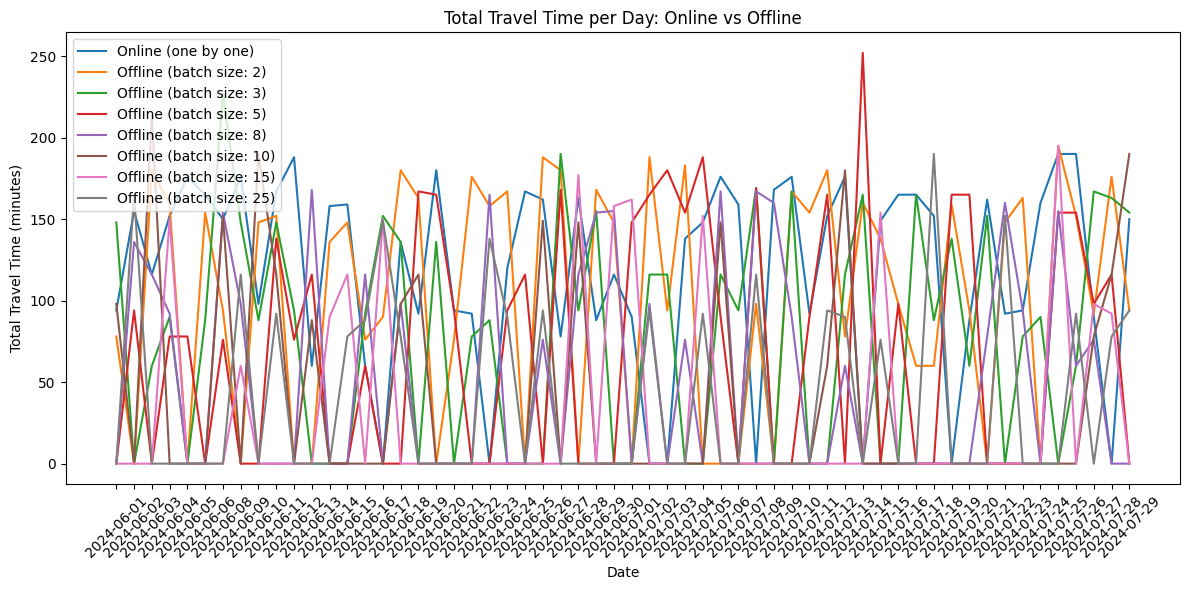

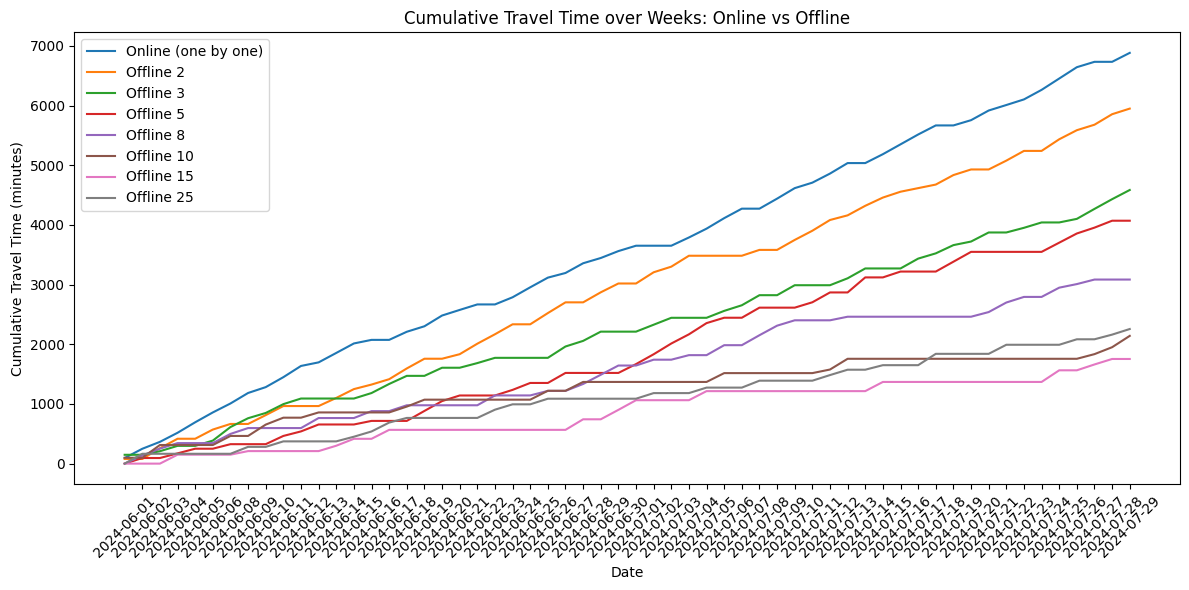

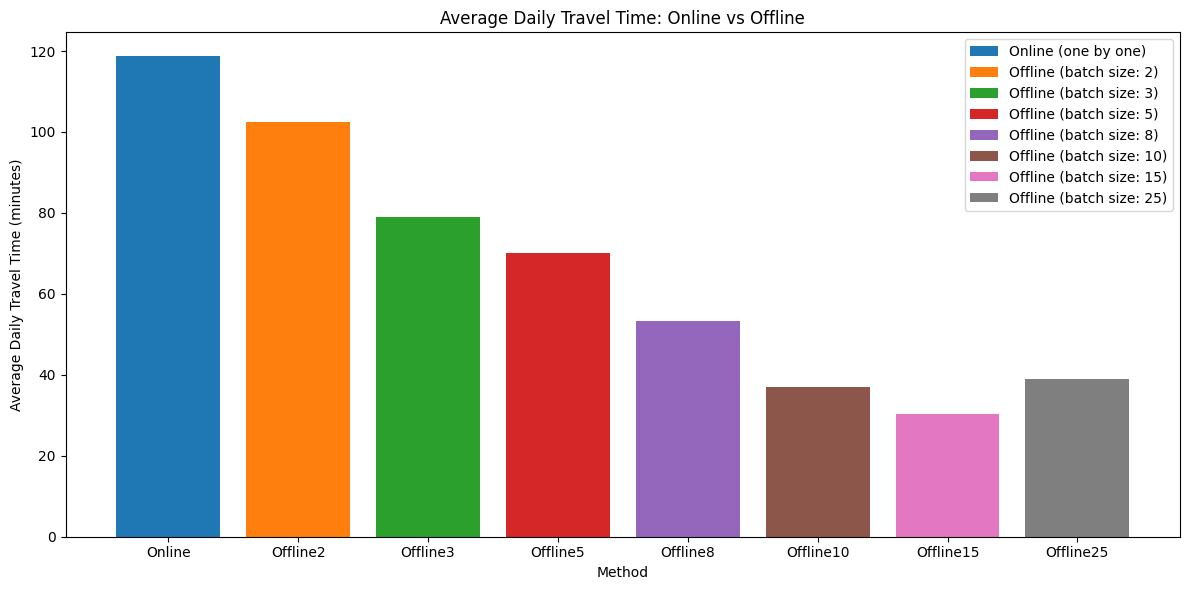

    Average Daily Travel Time (minutes)
1                            118.689655
2                            102.586207
3                             79.068966
5                             70.189655
8                             53.189655
10                            36.913793
15                            30.241379
25                            38.896552


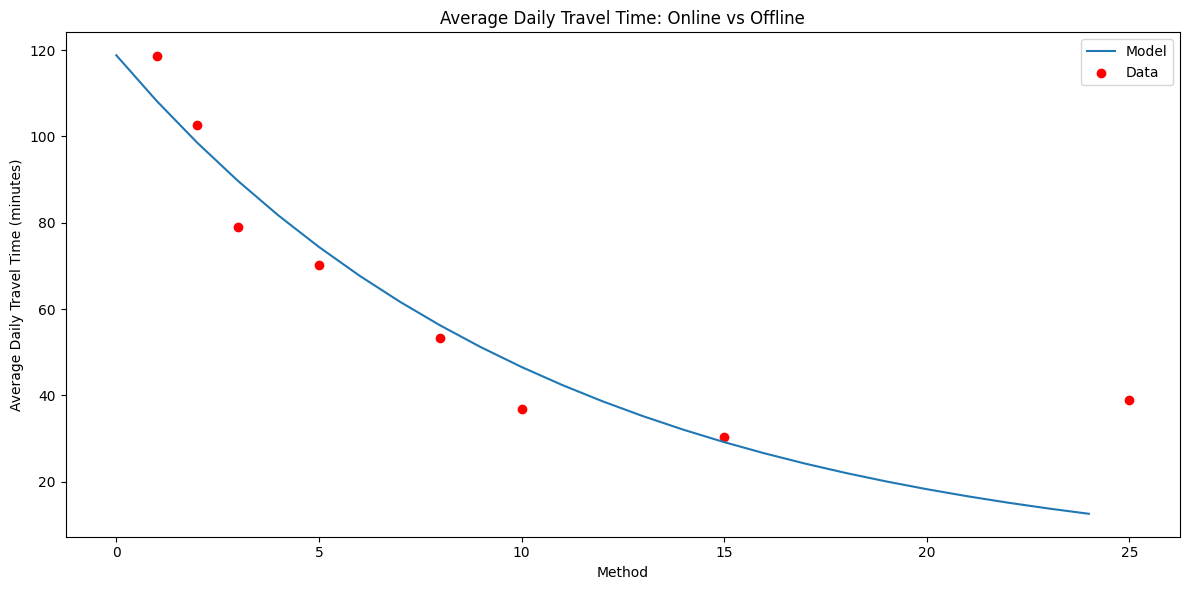

In [268]:
plot_travel_times(online_data, offline_data, batch_sizes)